# FitzHugh--Nagumo model

The FitzHugh–Nagumo model represents a model for the
study of excitable media. The propagation of the transmembrane potential $u$ is modeled by a diffusion equation with a cubic nonlinear reaction term, whereas the recovery of the slow variable $v$ is represented by a single ordinary differential equation. The system of equations reads as follows:

\begin{align}
\frac{\partial u}{\partial t} &= D \Delta u + u(1-u)(u-a) -v + S  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\frac{\partial v}{\partial t} &= \epsilon (\beta u - \gamma v) \qquad x \in \Omega \text{ and for } t \in [0, T]
\end{align}

$\Omega$ denotes the spatial domain and $t$ is time. We consider the following choice of model parameters: $K_u = 0.001$, $a = 0.1$, $\epsilon = 0.01$,
$\beta = 0.5$, $\gamma = 1.0.$ These parameters generate stable patterns in  the system in the form of re--entrant spiral waves.

$S$ is a stimulus that we use to perturb the system.

 # Semi-discrete problem and weak formulation

At each time step we have the semidiscretized system to solve:

\begin{align}
\frac{u^n - u^{n-1}}{\Delta t} &= D \Delta u^n + u^n(1-u^n)(u^n-a) - v^n + S  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\frac{v^n - v^{n-1}}{\Delta t} &= \epsilon (\beta u^n - \gamma v^n) \qquad x \in \Omega \text{ and for } t \in [0, T]
\end{align}

The weak formulation reads as follows:

Find $u^n$, $v^n$ s.t. 

\begin{align}
\langle \frac{u^n - u^{n-1}}{\Delta t}, \psi_u \rangle &= - D \langle \nabla u^n, \nabla \psi_u \rangle + \langle u^n(1-u^n)(u^n-a), \psi_u \rangle - \langle v^n, \psi_u \rangle + \langle S, \psi_u \rangle \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
\langle \frac{v^n - v^{n-1}}{\Delta t}, \psi_v\rangle &= \epsilon (\beta \langle u^n, \psi_v \rangle - \langle \gamma v^n, \psi_v \rangle ) \qquad x \in \Omega \text{ and for } t \in [0, T]  \text{ and for all} \quad \psi_u, \psi_v
\end{align}

## FEniCS implementation

First, we define our domain and finite elements. We have a system of two equations, therefore we will use a Mixed Function Space where the first component is $u$ and the second is $v$.

In [3]:
from dolfin import *
%matplotlib inline
import pylab

# Define the mesh
N = 32
mesh = RectangleMesh(Point(0, 0), Point(2.5, 2.5), N, N)

# Define the mixed finite elements
Ue = FiniteElement("CG", mesh.ufl_cell(), 1)
Us = FunctionSpace(mesh, Ue)

element = MixedElement([Ue,Ue])
ME = FunctionSpace(mesh, element)


# Lower the log level to get more verbose output
set_log_level(40)


We need to define our stimulus $S$ and boundary conditions: 

In [4]:
def BC_U_and_stim(t):
    ## returns tuple of BCs to apply (to V) and stimulus term at time t
    ## What happens when you play with this parameters?
    start_stim_end_time = 6
    stimstarttime = 150
    stimduration = 6.
    stimamp = 0.8
    
    if t < start_stim_end_time:
        # set a Dirichlet boundary condition of u=1 at left edge of the domain, but no stimulus term S
        subdomain = CompiledSubDomain("near(x[0], 0) && on_boundary")
        return [DirichletBC(ME.sub(0), Constant(1), subdomain)], Constant(0)
    
    elif t > stimstarttime and t < stimstarttime + stimduration:
        # have no Dirichlet boundary conditions, but a stimulus in the bottom left quarter of the domain
        class Stimulus(UserExpression):
            def eval(self, value, x):
                if x[0] < 1.25 and x[1] < 1.25:
                    value[0] = stimamp
                else:
                    value[0] = 0    
        return [], Stimulus(degree=2)

    else:
        # no stimulus and no Dirichlet boundrary conditions
        return [], Constant(0)


For each time step we need to solve a linear system. We define parameters, trial and test functions, and weak formulation. In FEniCS it is possible to obtain the Jacobian of the nonlinear equations automatically:

In [5]:
def solve_single_timestep(Up, t):
    u_p, v_p = Up.sub(0), Up.sub(1)
    U = Function(ME)
    dU = TrialFunction(ME)
    psiU = TestFunction(ME)

    u, v = split(U)
    psiu, psiv = split(psiU)


    a = Constant(0.1)
    eps = Constant(0.01)
    beta = Constant(0.5)
    gamma = Constant(1)
    D = Constant(1E-4)
    dtc = Constant(dt)
    
    bcs, stim = BC_U_and_stim(t)
 
    def RHS_E1(v, w):
        return - D*inner(grad(u), grad(psiu)) + psiu *u*(1-u)*(u-a)  - w*psiu  + stim*psiu
    def RHS_E2(v, w):
        return eps*(beta*v - gamma*w)*psiv
    
    theta = 1. # implicit Euler
    # theta = 0.5 # Crank-Nicholson
    
    F1 = (u - u_p)/dtc * psiu * dx - (theta * RHS_E1(u, v_p) + (1-theta) * RHS_E1(u_p, v_p)) * dx
    F2 = (v - v_p)/dtc * psiv * dx - (theta * RHS_E2(u, v) + (1-theta) * RHS_E2(u_p, v_p)) * dx



    F = F1 + F2
    
    # Automatic differentiation! Isn't it cool?
    J = derivative(F, U, dU)
    
    # Define non linear variational problem
    problem = NonlinearVariationalProblem(F, U, bcs, J)
    
    # Assign initial guess to Newton solver
    # Try to remove this, what happens?
    assign(U.sub(0), u_p)
    assign(U.sub(1), v_p)

    # Newton solver
    solver = NonlinearVariationalSolver(problem)
    niter, _ = solver.solve()

    print("t=%4.2f, number of Newton iterations=%2.0f\r" %(t, niter))

    return U


Once we defined the weak formulation and the nonlinear solver we can solve our equations for $t \leq T$:

In [91]:
# initial conditions
u_p = Function(Us)
v_p = Function(Us)
U = Function(ME)

# run solver

# optional saving to file
#fv = File("output/u.pvd")
#fw = File("output/v.pvd")

t = 0
dt = 4.
T = 500

U_sol = {}
n = 0

fig = pylab.figure()
while t <= T:
    t += dt
    n += 1
    U = solve_single_timestep(U, t)
    u_p.rename("u", "descr")
    v_p.rename("v", "descr")
    
    U_sol[n] = (t, U.copy())
    
    # save to file
    
    #fv << u_p
    #fw << v_p


t=4.00, number of Newton iterations= 5
t=8.00, number of Newton iterations= 5
t=12.00, number of Newton iterations= 7
t=16.00, number of Newton iterations= 5
t=20.00, number of Newton iterations= 7
t=24.00, number of Newton iterations= 5
t=28.00, number of Newton iterations= 6
t=32.00, number of Newton iterations= 7
t=36.00, number of Newton iterations= 6
t=40.00, number of Newton iterations= 7
t=44.00, number of Newton iterations= 6
t=48.00, number of Newton iterations= 7
t=52.00, number of Newton iterations=14
t=56.00, number of Newton iterations= 8
t=60.00, number of Newton iterations= 6
t=64.00, number of Newton iterations= 7
t=68.00, number of Newton iterations= 7
t=72.00, number of Newton iterations= 7
t=76.00, number of Newton iterations= 7
t=80.00, number of Newton iterations= 6
t=84.00, number of Newton iterations= 7
t=88.00, number of Newton iterations= 7
t=92.00, number of Newton iterations= 7
t=96.00, number of Newton iterations= 7
t=100.00, number of Newton iterations= 6
t

In [92]:
## make a 'slider-controlled movie'

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider,  HBox, Label
import ipywidgets as widgets

def plot_solution(n):
    t, U = U_sol[n]
    pylab.subplot(1, 2, 1)
    plot(U.sub(0), title="potential (t = {})".format(t))
    pylab.subplot(1, 2, 2)
    plot(U.sub(1), title="recovery variable (t = {})".format(t))
    

slider = IntSlider(min=min(U_sol.keys()), max=max(U_sol.keys()),continuous_update=False)
slider.layout.width = "80%"
interact(plot_solution,n=slider)

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'n', layout=Layout(width=u'80%'), max=126, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_solution>

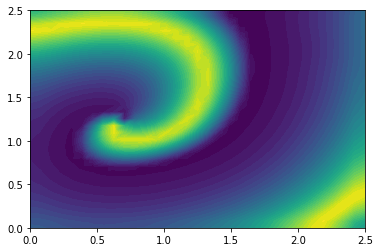

In [109]:
# very slow but functional animation

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

    
# initialization function: plot the background of each frame
# to be honest i don't actually know what this is supposed to do, so it's probably doing something wrong
def init():
    return (ax,)

#dolfin.common.plotting.mplot_function(ax, U.sub(0))

# animation function. This is called sequentially
def animate(i):
    dolfin.common.plotting.mplot_function(ax, U_sol[i+1][1].sub(1))
    return (ax,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(U_sol.keys())-1, interval=30, blit=False)

HTML(anim.to_html5_video())
#HTML(anim.to_jshtml()) # allegedly newer and better but fails for me